# 224x224 Retina Fotoğraflarından Diyabetik Retinopati Tespiti ve Sınıflandırma projesi

# Diabetic Retinopathy Detection and Classification Project from 224x224 Retinal Photos

*İsmail DUMLU 240711003* \
*M. Mirza ERDEM 240711012* \
*M Selçuk İNCİ 240711020*

In [1]:
# =========================
# 0) Temel kütüphaneler
# =========================
import pandas as pd              # Tablo/veri işlemleri (CSV, DataFrame)
import numpy as np               # Sayısal işlemler
import matplotlib.pyplot as plt  # Grafik çizimleri

# =========================
# 1) Derin öğrenme (TensorFlow / Keras)
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model ve eğitim yardımcıları
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Veri artırma ve EfficientNet yardımcıları
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input  # EfficientNet için doğru normalize

# =========================
# 2) Klasik ML yardımcıları (scikit-learn)
# =========================
from sklearn.model_selection import train_test_split     # Train/val bölme (stratify için önemli)
from sklearn.utils import class_weight                   # Sınıf ağırlıkları (dengesiz veri için)

# Değerlendirme metrikleri
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    cohen_kappa_score
)

# =========================
# 3) Görüntü işleme (opsiyonel)
# =========================
import cv2  # Şu an ana pipeline'da aktif kullanmıyoruz; crop/CLAHE gibi denemeler için tutulabilir

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetic-retinopathy-224x224-2019-data' dataset.
Path to dataset files: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [3]:
!ls -l {path} # Dataset dizininin içeriğini kontrol et (klasörler, dosyalar doğru mu?)

total 56
drwxr-sr-x 7 1000 1000     0 Dec 18 23:11 colored_images
-rw-r--r-- 1 1000 1000 54948 Dec 18 23:11 train.csv


In [4]:
# Eğitim etiketlerini içeren CSV dosyasını oku
# Bu dosya: image id + diagnosis (0–4) bilgilerini tutar
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv")

# İlk birkaç satırı kontrol ederek kolon isimlerini ve formatı gör
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
# Görsel ID'leri (dosya isimleri) ve etiketleri ayır
x = df["id_code"]       # Görsel kimlikleri
y = df["diagnosis"]     # Sınıf etiketleri (0–4)

# Stratify=y:
# → Train ve validation setlerinde sınıf dağılımı korunur (çok kritik!)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [6]:
# colored_images dizininin içeriğini kontrol et
# (sınıf klasörleri ve görseller gerçekten burada mı?)
!ls -l {data_dir}

ls: cannot access '{data_dir}': No such file or directory


In [7]:
# Sayısal etiketleri (0–4) klasör isimlerine eşlemek için mapping
# Görseller colored_images/<class_name>/ altında tutulduğu için bu map şart
diagnosis_map = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Kontrol: mapping doğru mu?
print(diagnosis_map)

{0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}


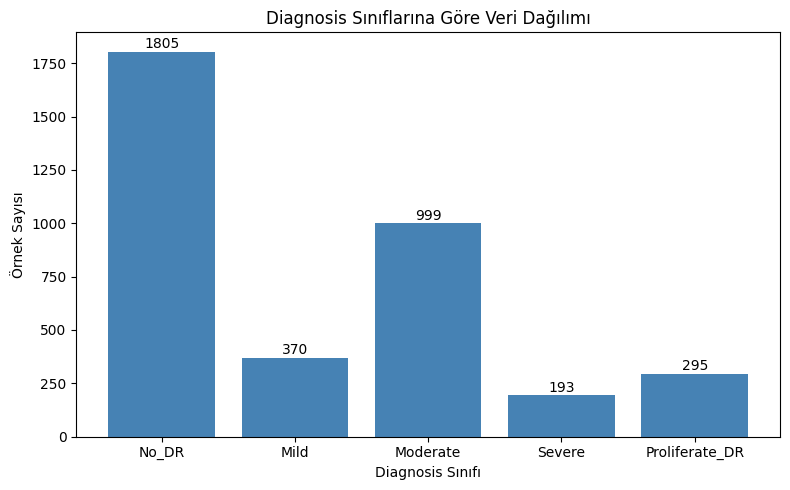

In [8]:
# diagnosis (0–4) değerlerinin kaç kez geçtiğini say
# Bu dağılım, veri setinin ne kadar dengesiz olduğunu gösterir
class_counts = df["diagnosis"].value_counts().sort_index()

# Sınıf isimlerini diagnosis_map'ten sırayla al
labels = [diagnosis_map[i] for i in class_counts.index]
counts = class_counts.values

plt.figure(figsize=(8, 5))

# Bar plot: her sınıf için örnek sayısı
plt.bar(labels, counts, color="steelblue")

# Eksen ve başlık
plt.xlabel("Diagnosis Sınıfı")
plt.ylabel("Örnek Sayısı")
plt.title("Diagnosis Sınıflarına Göre Veri Dağılımı")

# Bar'ların üstüne sayıları yaz
for i, count in enumerate(counts):
    plt.text(i, count + counts.max() * 0.01, str(count), ha="center")

plt.tight_layout()
plt.show()

In [9]:
# Modelin beklediği giriş boyutu (EfficientNet için 224x224)
image_size = (224, 224)
batch_size = 32


# Eğitim verisi için ImageDataGenerator
# preprocess_input:
# → EfficientNet'in ImageNet üzerinde öğrendiği piksel dağılımına uygun dönüştürme
# Augmentasyonlar:
# → Veri çeşitliliğini artırır, overfitting'i azaltır
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.1,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation verisi için generator
# → Augmentasyon YOK, sadece preprocess_input
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [10]:
# Train / Validation DataFrame'lerini oluştur
# id_code  : görsel dosya adı (uzantısız)
# diagnosis: sınıf etiketi (0–4)
train_df = pd.DataFrame({
    "id_code": x_train,
    "diagnosis": y_train
})

val_df = pd.DataFrame({
    "id_code": x_test,
    "diagnosis": y_test
})

# diagnosis (0–4) -> klasör adı eşlemesi
# Örn: 0 -> No_DR, 1 -> Mild, ...
train_df["folder_name"] = train_df["diagnosis"].map(diagnosis_map)
val_df["folder_name"] = val_df["diagnosis"].map(diagnosis_map)

# flow_from_dataframe için göreli dosya yolu oluştur
# Bu yol, directory=data_dir ile birleştirilecek
train_df["image_path"] = train_df["folder_name"] + "/" + train_df["id_code"] + ".png"
val_df["image_path"] = val_df["folder_name"] + "/" + val_df["id_code"] + ".png"

# Kontrol: path ve etiketler doğru mu?
display(train_df.head())
display(val_df.head())

,id_code,diagnosis,folder_name,image_path
2579,b2b79b37d314,0,No_DR,No_DR/b2b79b37d314.png
309,175dd560810a,2,Moderate,Moderate/175dd560810a.png
2826,c3cd0200df79,3,Severe,Severe/c3cd0200df79.png
2989,cfed7c1172ec,0,No_DR,No_DR/cfed7c1172ec.png
3344,e811f39a1243,2,Moderate,Moderate/e811f39a1243.png


,id_code,diagnosis,folder_name,image_path
1595,6fe67fd7f5d1,0,No_DR,No_DR/6fe67fd7f5d1.png
3449,ef8c39eb9157,0,No_DR,No_DR/ef8c39eb9157.png
1394,61bbc11fe503,4,Proliferate_DR,Proliferate_DR/61bbc11fe503.png
1379,60edda7b4871,0,No_DR,No_DR/60edda7b4871.png
3043,d30d079e6f9a,0,No_DR,No_DR/d30d079e6f9a.png


In [11]:
# colored_images klasörünün kök dizini
# flow_from_dataframe, image_path ile bunu birleştirerek dosyayı bulur
data_dir = path + "/colored_images"

# image_size = (224,224) olduğu için tek değeri alıyoruz
img_size = image_size[0]

# Eğitim generator'ı
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="image_path",      # Göreli dosya yolu (folder/filename.png)
    y_col="diagnosis",       # Integer etiket (0–4)
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="raw",        # Sparse loss ile uyumlu (one-hot YOK)
    shuffle=True,            # Eğitimde karıştırmak şart
    seed=42                  # Tekrar üretilebilirlik
)

# Validation generator'ı
# shuffle=False → y_true / y_pred hizası BOZULMASIN diye
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_dir,
    x_col="image_path",
    y_col="diagnosis",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="raw",
    shuffle=False
)

# Sınıf isimleri (raporlar ve confusion matrix için)
class_names = [diagnosis_map[i] for i in sorted(diagnosis_map.keys())]
print("Classes:", class_names)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


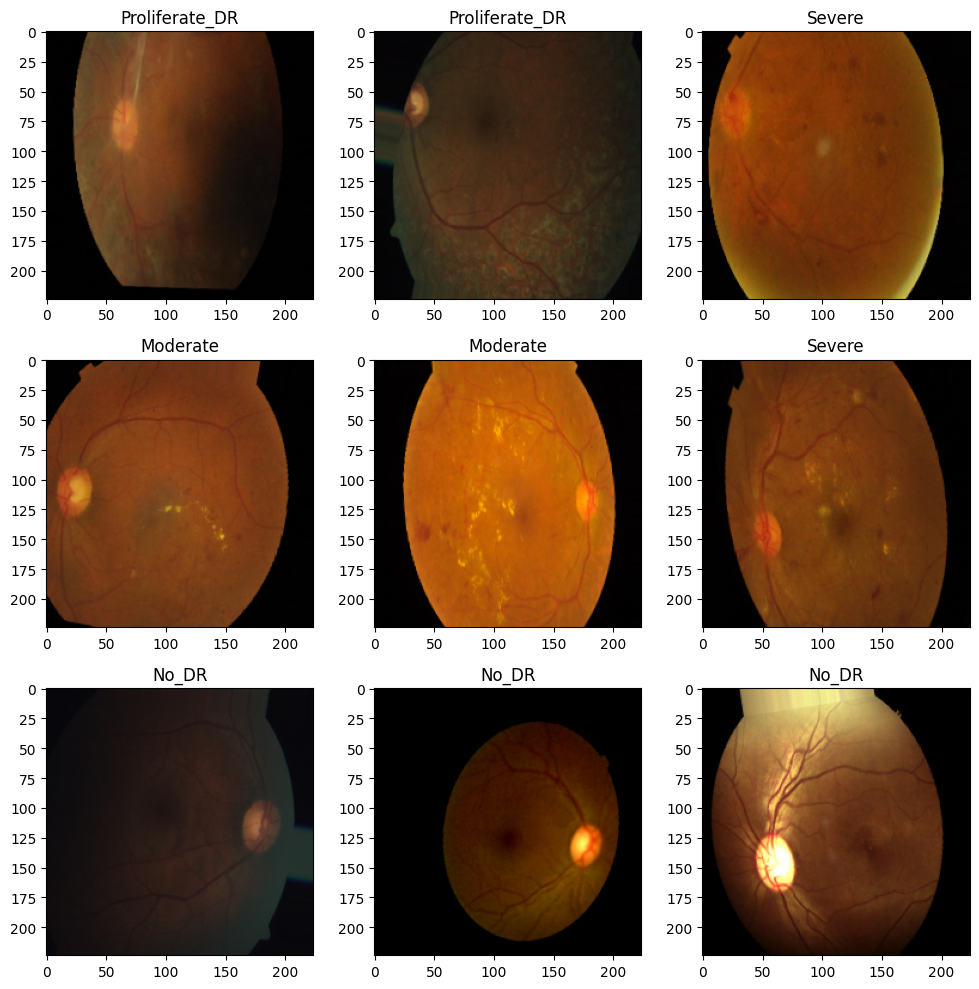

In [12]:
# Eğitim generator'ından rastgele bir batch al
# Bu hücre SADECE görsel kontrol (debug) içindir, eğitimi etkilemez
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # class_mode="raw" olduğu için labels[i] doğrudan integer (0–4)
    label_index = int(labels[i])
    plt.title(class_names[label_index])

    # preprocess_input uygulanmış tensörü görselleştirmek için
    # uint8'e çeviriyoruz (modelde bu şekilde kullanılmıyor!)
    plt.imshow(images[i].astype("uint8"))

plt.tight_layout()
plt.show()

In [13]:
# EfficientNetB0 backbone'u yüklüyoruz
# include_top=False → ImageNet classifier kısmını çıkarıyoruz
# weights="imagenet" → önceden eğitilmiş ağırlıkları kullanıyoruz
# input_shape → generator'dan gelen görüntü boyutuyla birebir olmalı
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size, img_size, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
# Sınıf indekslerini NET tanımlıyoruz (0–4)
# Böylece ağırlıklar yanlış sınıfa kaymaz
classes = np.array([0, 1, 2, 3, 4])

# Eğitim verisindeki sınıf dengesizliğine göre ağırlıkları hesapla
# "balanced" → az görülen sınıflara daha yüksek ağırlık verir
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

# Keras'ın beklediği format: {class_index: weight}
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

# Kontrol amaçlı yazdır
print("Hesaplanan Sınıf Ağırlıkları:", class_weights)

Hesaplanan Sınıf Ağırlıkları: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}


In [15]:
# EfficientNetB0 backbone (özellik çıkarıcı)
# include_top=False → ImageNet classifier kısmı yok
# weights="imagenet" → önceden öğrenilmiş görsel temsiller
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size, img_size, 3)
)

# Stage 1: backbone dondurulu
# → Sadece eklediğimiz (head) katmanlar eğitilecek
base_model.trainable = False

# Model girişi
inputs = keras.Input(shape=(img_size, img_size, 3))

# Backbone üzerinden feature çıkarımı
# training=False → BatchNorm davranışı stabil kalsın
x = base_model(inputs, training=False)

# Spatial boyutları ortalamaya indir
x = layers.GlobalAveragePooling2D()(x)

# Öğrenilebilir temsil (head)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)   # Overfitting'i azaltır

# Çıkış katmanı (5 sınıf)
outputs = layers.Dense(5, activation="softmax")(x)

# Tam model
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
# Model mimarisini ve trainable / non-trainable parametreleri kontrol et
# → Head katmanlar var mı?
# → Backbone gerçekten dondurulmuş mu?
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
print("\n--- 1. AŞAMA: ISINMA (Sadece head) ---")

# Stage 1: backbone dondurulu (head hızlı otursun)
base_model.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",  # sparse label (0–4) ile uyumlu
    metrics=["accuracy"]
)

# Warmup için de basit LR scheduler + early stop koymak stabilite sağlar (opsiyonel ama faydalı)
warmup_callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7, verbose=1),
]

history_warmup = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=warmup_callbacks,
    verbose=1
)

print("\n--- 2. AŞAMA: İNCE AYAR (Soft Class Weights + Weighted Focal Loss) ---")

# =========================================================
# 1) Fine-tuning ayarı
# =========================================================
# Backbone'u (EfficientNet) tamamen açıyoruz
# fakat yalnızca son 30 katman eğitilebilir olacak
# → erken katmanlar genel görsel özellikleri korur
# → son katmanlar DR'ye özgü olarak adapte olur
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False


# =========================================================
# 2) Class weight'leri yumuşatma (soften)
# =========================================================
# Otomatik balanced class_weight'ler bazen çok agresif olabilir
# Bu da modelin tek bir sınıfa (çoğunlukla Moderate) kaymasına yol açar
# Amaç: sınıflar arası güç farkını tamamen silmeden yumuşatmak

# Ham class weight'leri numpy vektörüne çevir
cw_raw = np.array([class_weights[i] for i in range(5)], dtype=np.float32)

# Ortalama 1 olacak şekilde normalize et
# → loss ölçeği kontrol altında kalsın
cw_raw = cw_raw / cw_raw.mean()

# SOFTEN parametresi:
# 0.0  → tüm ağırlıklar 1 (class weight yok)
# 1.0  → ham class weight'ler
# 0.6  → ikisinin dengeli karışımı (önerilen)
SOFTEN = 0.6
cw = 1.0 + SOFTEN * (cw_raw - 1.0)

# Aşırı uçları kırp
# → çok küçük ağırlıklar sınıfı yok saymasın
# → çok büyük ağırlıklar modeli tek sınıfa sürüklemesin
cw = np.clip(cw, 0.8, 2.2).astype(np.float32)

print("CW raw (normalized):", cw_raw)
print("CW soft (used):", cw)


# =========================================================
# 3) Weighted Sparse Focal Loss tanımı
# =========================================================
# Focal loss: zor örneklere daha fazla odaklanır
# Gamma küçüldükçe (1.4) agresiflik azalır
# → Mild / Proliferate gibi sınıfların tamamen bastırılması engellenir
GAMMA = 1.4

def weighted_sparse_focal_loss(class_weights_vec, gamma=1.4, num_classes=5):
    # class_weights sabit tensor olarak tutulur
    class_weights_vec = tf.constant(class_weights_vec, dtype=tf.float32)

    def loss(y_true, y_pred):
        # y_true: (batch,) → integer etiketler
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)

        # Integer etiketleri one-hot forma çevir
        y_true_oh = tf.one_hot(y_true, depth=num_classes)

        # p_t: modelin doğru sınıfa verdiği olasılık
        p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)

        # log(0) hatasını önlemek için kırpma
        p_t = tf.clip_by_value(p_t, 1e-7, 1.0 - 1e-7)

        # Her örnek için sınıf ağırlığını al
        w = tf.gather(class_weights_vec, y_true)

        # Weighted focal loss formülü
        fl = - w * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return fl

    return loss


# =========================================================
# 4) Modeli yeniden derle (fine-tune aşaması)
# =========================================================
# Öğrenme hızı çok düşük tutulur
# → önceden öğrenilmiş ağırlıklar bozulmasın
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=weighted_sparse_focal_loss(cw, gamma=GAMMA, num_classes=5),
    metrics=["accuracy"]
)


# =========================================================
# 5) Callback'ler
# =========================================================
# EarlyStopping: overfitting'i önler
# ModelCheckpoint: en iyi validation loss'lu modeli kaydeder
# ReduceLROnPlateau: validation iyileşmezse LR düşürür
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "best_diabetic_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


# =========================================================
# 6) Fine-tune eğitimi (Stage 2)
# =========================================================
# Bu aşamada:
# - class_weight kullanılmaz
# - ağırlıklandırma tamamen loss fonksiyonunun içindedir
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)



--- 1. AŞAMA: ISINMA (Sadece head) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.6192 - loss: 1.0622 - val_accuracy: 0.7613 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.7655 - loss: 0.6163 - val_accuracy: 0.7340 - val_loss: 0.7361 - learning_rate: 0.0010
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.7890 - loss: 0.5666 - val_accuracy: 0.7763 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.7913 - loss: 0.5580 - val_accuracy: 0.7681 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7997 - loss: 0.5215
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
92/92 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.7997 - loss: 0.5216 - val_accuracy: 0.7449 - val_loss: 0.6369 - learning_rate: 0.0010

--- 2. AŞAMA: İNCE AYAR (Soft Class Weights + Weighted Focal Loss) ---
CW raw (normalized): [0.21569

In [18]:
# Eğitim sonunda kritik konfigürasyonları kontrol et
# → Gerçekten fine-tune modunda mıyız?
# → Doğru loss ve class_mode kullanılıyor mu?

print("LR:", float(model.optimizer.learning_rate.numpy()))
# Fine-tune aşamasında düşük olmalı (örn. ~1e-5)

print("Loss:", model.loss)
# weighted_sparse_focal_loss görmelisin (Stage 2 için)

print("Trainable layers:", sum(l.trainable for l in model.layers))
# >0 olmalı; sadece head değil, backbone'un son katmanları da açık mı diye bak

print("Class mode:", getattr(train_generator, "class_mode", None))
# 'raw' olmalı → sparse loss ile uyumlu

LR: 4.0000000467443897e-07
Loss: <function weighted_sparse_focal_loss.<locals>.loss at 0x7ea0c9cb5120>
Trainable layers: 6
Class mode: raw


In [19]:
# Validation generator'ı başa sar
# → predict ile labels hizalı olsun
validation_generator.reset()

# Tahmin olasılıkları (N, 5)
pred = model.predict(validation_generator, verbose=0)
y_pred = np.argmax(pred, axis=1)

# Ground truth'u generator'dan al (shuffle=False olduğu için birebir hizalı)
y_true = validation_generator.labels.astype(int)

print("pred len:", len(y_pred))
print("y_true len:", len(y_true))
print("val shuffle:", getattr(validation_generator, "shuffle", None))

# Her sınıf için tahmin sayısı (0..4) — minlength=5 ile garanti
print("pred class counts:", np.bincount(y_pred, minlength=5))

pred len: 733
y_true len: 733
val shuffle: False
pred class counts: [356 104 222  24  27]


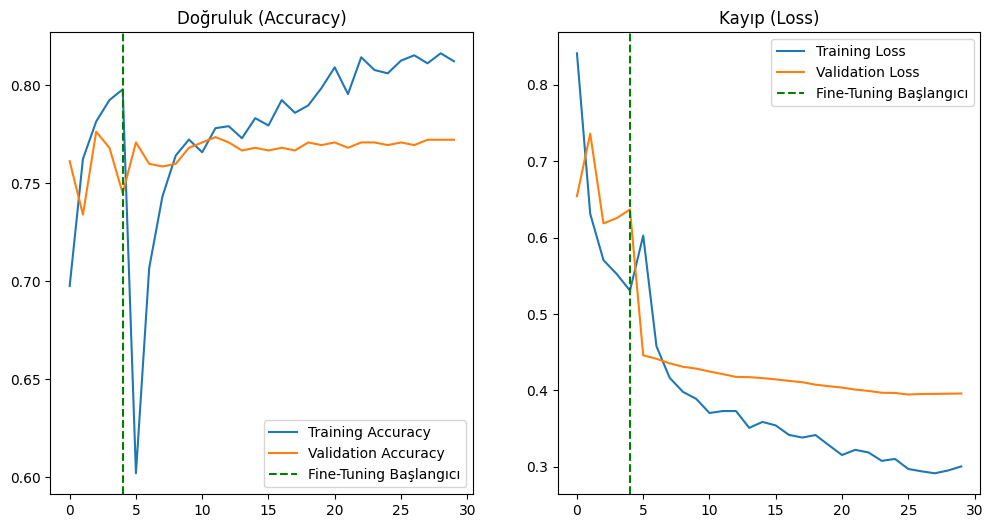

In [20]:
# Warmup + Fine-tune eğitim geçmişlerini birleştiriyoruz
# Böylece tek bir eğitim süreci gibi görselleştirebiliriz
acc = history_warmup.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history_warmup.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history_warmup.history["loss"] + history_finetune.history["loss"]
val_loss = history_warmup.history["val_loss"] + history_finetune.history["val_loss"]

# Warmup epoch sayısı (dikey çizgi için)
warmup_epochs = len(history_warmup.history["accuracy"])

plt.figure(figsize=(12, 6))

# --- Accuracy plot ---
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

# Fine-tuning başlangıcını göster
plt.axvline(
    x=warmup_epochs - 1,
    color="g",
    linestyle="--",
    label="Fine-Tuning Başlangıcı"
)

plt.title("Doğruluk (Accuracy)")
plt.legend()

# --- Loss plot ---
plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.axvline(
    x=warmup_epochs - 1,
    color="g",
    linestyle="--",
    label="Fine-Tuning Başlangıcı"
)

plt.title("Kayıp (Loss)")
plt.legend()

plt.show()

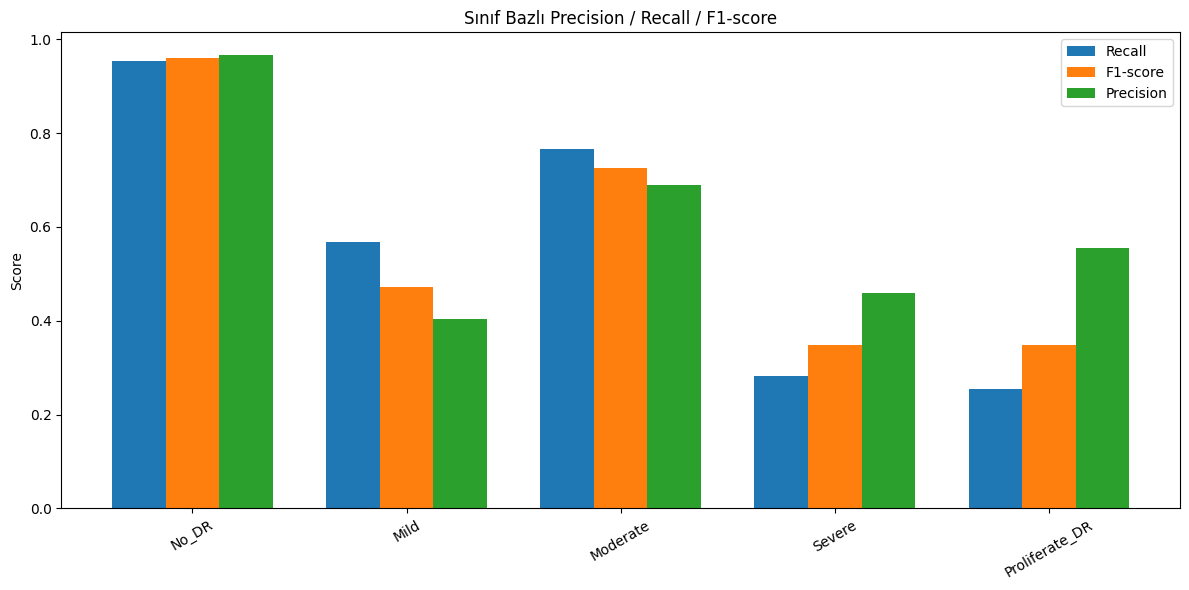

In [21]:
# Classification report'u sözlük (dict) formatında al
# output_dict=True → metrikleri tek tek çekebilmek için
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)

# Sınıf bazlı metrik listeleri
precision_vals = []  # Precision (pozitif tahminlerin doğruluğu)
recall_vals = []     # Recall (kaçırmama oranı)
f1_vals = []         # F1-score (precision & recall dengesi)
support_vals = []    # Support (sınıfa ait örnek sayısı)

# Her sınıf için metrikleri sırayla al
for cls in class_names:
    precision_vals.append(report[cls]["precision"])
    recall_vals.append(report[cls]["recall"])
    f1_vals.append(report[cls]["f1-score"])
    support_vals.append(report[cls]["support"])

# Bar plot için x ekseni
x = np.arange(len(class_names))
width = 0.25  # Bar genişliği

plt.figure(figsize=(12, 6))

# Her metrik için ayrı bar (yan yana)
plt.bar(x - width, recall_vals, width, label="Recall")
plt.bar(x, f1_vals, width, label="F1-score")
plt.bar(x + width, precision_vals, width, label="Precision")

# Eksen ve başlık ayarları
plt.xticks(x, class_names, rotation=30)
plt.ylabel("Score")
plt.title("Sınıf Bazlı Precision / Recall / F1-score")
plt.legend()

# Layout düzeltme (etiketler taşmasın)
plt.tight_layout()
plt.show()

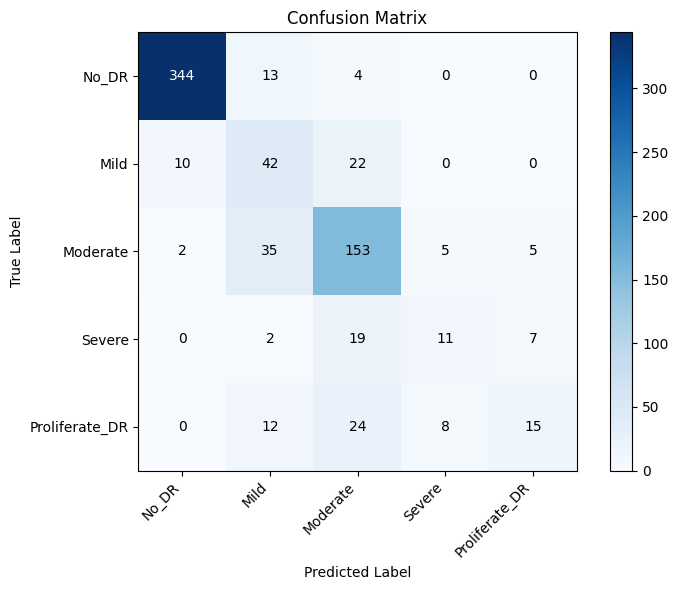

In [22]:
# Gerçek etiketler (y_true) ve model tahminleri (y_pred) ile
# confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))

# Confusion matrix'i ısı haritası (heatmap) olarak çiz
# Mavi tonları: düşükten yükseğe değerleri temsil eder
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()  # Renk skalasını göster

# Eksenlerde sınıf isimlerini göster
# Satırlar: gerçek sınıflar
# Sütunlar: modelin tahmin ettiği sınıflar
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Hücrelerin içine sayısal değerleri yaz
# thresh → yazı rengini ayarlamak için eşik (okunabilirlik)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],        # (i,j) hücresindeki örnek sayısı
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

# Eksen açıklamaları
plt.ylabel("True Label")        # Gerçek sınıf
plt.xlabel("Predicted Label")   # Model tahmini

# Yerleşimi sıkıştır (etiketler taşmasın)
plt.tight_layout()
plt.show()

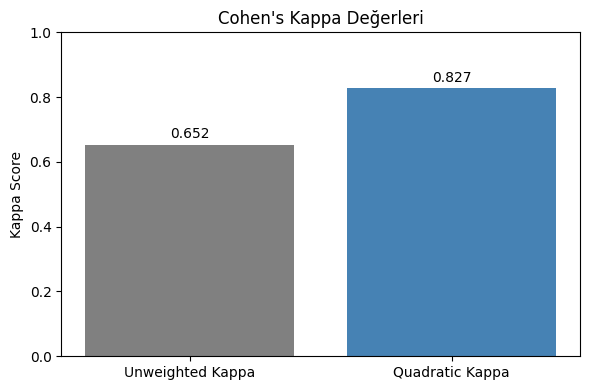

In [23]:
# Cohen's Kappa değerlerini hesapla
# Unweighted → tüm hataları eşit sayar
kappa_unweighted = cohen_kappa_score(y_true, y_pred)

# Quadratic → ordinal problemler için daha anlamlı
# (Mild ↔ Moderate hatası, No_DR ↔ Proliferate kadar ağır sayılmaz)
kappa_quadratic = cohen_kappa_score(y_true, y_pred, weights="quadratic")

# Kappa değerlerini görselleştir
plt.figure(figsize=(6, 4))

plt.bar(
    ["Unweighted Kappa", "Quadratic Kappa"],
    [kappa_unweighted, kappa_quadratic],
    color=["gray", "steelblue"]
)

# Kappa teorik olarak [-1, 1] aralığında
# Burada [0, 1] kullanıyoruz (negatif beklenmez)
plt.ylim(0, 1)
plt.ylabel("Kappa Score")
plt.title("Cohen's Kappa Değerleri")

# Bar'ların üstüne sayısal değerleri yaz
for i, val in enumerate([kappa_unweighted, kappa_quadratic]):
    plt.text(
        i,
        val + 0.02,
        f"{val:.3f}",
        ha="center"
    )

plt.tight_layout()
plt.show()